In [58]:
import argparse
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from tensorboardX import SummaryWriter

import fastmri
from fastmri.data import transforms
from fastmri.models.unet import Unet
from fastmri.models.varnet import *

import sigpy.plot as pl
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
import skimage.metrics

from dloader import genDataLoader

In [57]:
# command line argument parser
parser = argparse.ArgumentParser(
    description = 'define parameters and roots for STL training'
)

parser.add_argument(
    '--scarcities', default=[0, 1], type=int, nargs='+',
    help='number of samples will be decreased by 1/2^N; match with roots'
    )

parser.add_argument(
    '--dataroots', nargs='+',
    help='paths of data files; match with scarcities',
#     required = True
)

parser.add_argument(
    '--epochs', default=30, type=int,
    help='number of epochs to run'
)

parser.add_argument(
    '--lr', default=0.001, type=float,
    help='learning rate'
)

parser.add_argument(
    '--modelpath', default='models/best-no-name.pt',
    help='path to save best model'
)

opt = parser.parse_args()

usage: ipykernel_launcher.py [-h] [--scarcities SCARCITIES [SCARCITIES ...]]
                             [--dataroots DATAROOTS [DATAROOTS ...]]
                             [--epochs EPOCHS] [--lr LR]
                             [--modelpath MODELPATH]
ipykernel_launcher.py: error: unrecognized arguments: -f /home_local/vliu/.local/share/jupyter/runtime/kernel-fe36f15a-ee22-4910-9792-ac6894448ee4.json


SystemExit: 2

In [70]:
# We can make one iteration block like this
class VarNetBlock(nn.Module):
    """
    This model applies a combination of soft data consistency with the input
    model as a regularizer. A series of these blocks can be stacked to form
    the full variational network.
    """

    def __init__(self, model: nn.Module):
        """
        Args:
            model: Module for "regularization" component of variational
                network.
        """
        super().__init__()

        self.model = model
        self.eta = nn.Parameter(torch.ones(1))

    def sens_expand(self, x: torch.Tensor, sens_maps: torch.Tensor) -> torch.Tensor:
        return fastmri.fft2c(fastmri.complex_mul(x, sens_maps)) # F*S operator

    def sens_reduce(self, x: torch.Tensor, sens_maps: torch.Tensor) -> torch.Tensor:
        x = fastmri.ifft2c(x)
        return fastmri.complex_mul(x, fastmri.complex_conj(sens_maps)).sum(
            dim=1, keepdim=True
        ) # S^H * F^H operator

    def forward(
        self,
        current_kspace: torch.Tensor,
        ref_kspace: torch.Tensor,
        mask: torch.Tensor,
        sens_maps: torch.Tensor,
    ) -> torch.Tensor:
        zero = torch.zeros(1, 1, 1, 1, 1).to(current_kspace)
        soft_dc = torch.where(mask, current_kspace - ref_kspace, zero) * self.eta
        model_term = self.sens_expand(
            self.model(self.sens_reduce(current_kspace, sens_maps)), sens_maps
        )

        return current_kspace - soft_dc - model_term

In [71]:
# now we can stack VarNetBlocks to make a unrolled VarNet (with 10 blocks)


class VarNet(nn.Module):
    """
    A full variational network model.

    This model applies a combination of soft data consistency with a U-Net
    regularizer. To use non-U-Net regularizers, use VarNetBock.
    """

    def __init__(
        self,
        num_cascades: int = 12,
        chans: int = 18,
        pools: int = 4,
    ):
        super().__init__()

        self.cascades = nn.ModuleList(
            [VarNetBlock(NormUnet(chans, pools)) for _ in range(num_cascades)]
        )
        
        # xavier initialization ??
        for m in self.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            nn.init.xavier_normal_(m.weight)
            nn.init.constant_(m.bias, 0)

    def forward(
        self,
        masked_kspace: torch.Tensor, 
        mask: torch.Tensor,
        sens_maps: torch.Tensor
    ) -> torch.Tensor:
        
        kspace_pred = masked_kspace.clone()

        for cascade in self.cascades:
            kspace_pred = cascade(kspace_pred, masked_kspace, mask, sens_maps)
        
        im_coil = fastmri.ifft2c(kspace_pred)
        im_comb = fastmri.complex_mul(im_coil, fastmri.complex_conj(sens_maps)).sum(
            dim=1, keepdim=True
        )
        
        return im_comb

In [59]:
def count_parameters(model):
    return sum(
        p.numel() for p in model.parameters() if p.requires_grad
    )

def criterion(im_fs: torch.Tensor, im_us: torch.Tensor):
    '''
    @parameter im_us: undersampled image (2D)
    @parameter im_fs: fully sampled image (2D)
    should be on GPU device for fast computation
    '''
    
    # use l1 loss between two images
    criterion = nn.L1Loss()
    
    # can add more fancy loss functions here later
    
    return criterion(im_us, im_fs)


def metrics(im_fs: torch.Tensor, im_us: torch.Tensor):
    '''
    @parameter im_us: undersampled image (2D)
    @parameter im_fs: fully sampled image (2D)
    should be on GPU device for fast computation
    '''

    # change to ndarray
    im_us = transforms.tensor_to_complex_np(im_us.cpu().detach())
    im_fs = transforms.tensor_to_complex_np(im_fs.cpu().detach())
    
    # convert complex nums to magnitude
    im_us = np.absolute(im_us)
    im_fs = np.absolute(im_fs)
    
    im_us = im_us.reshape(
        (im_us.shape[2], im_us.shape[3])
    )
    
    im_fs = im_fs.reshape(
        (im_fs.shape[2], im_fs.shape[3])
    )
    
    # psnr
    psnr = skimage.metrics.peak_signal_noise_ratio(
        im_fs, 
        im_us, 
        data_range = np.max(im_fs) - np.min(im_fs)
    )
    
    #nrmse
    nrmse = skimage.metrics.normalized_root_mse(im_fs, im_us)
    
    # ssim
    # normalize 0 to 1
    im_fs -= np.min(im_fs)
    im_fs /= np.max(im_fs)
    im_us -= np.min(im_us)
    im_us /= np.max(im_us)
    
    ssim = skimage.metrics.structural_similarity(im_fs, im_us, data_range = 1)
    
    return ssim, psnr, nrmse

In [92]:
"""
=========== Universal Single-task Trainer =========== 
code modified from https://github.com/lorenmt/mtan/blob/master/im2im_pred/utils.py
"""


def single_task_trainer(
    train_loader, test_loader, 
    single_task_model, device, 
    optimizer, scheduler,
    writer,
    opt = 0, total_epochs=2 ###opt###
):
    
    train_batch = len(train_loader)
    test_batch = len(test_loader)
    
    best_val_loss = np.infty
    
    # contains info for all epochs
    avg_cost = np.zeros([total_epochs, 8], dtype = np.float32) 
    for index in range(total_epochs):
        # contains info for single epoch
        cost = np.zeros(8, dtype = np.float32)

        # train data
        single_task_model.train()
        train_dataset = iter(train_loader)
    
        for _ in range(train_batch):
            kspace, mask, sens, im_fs, contrast = next(train_dataset)
            kspace, mask = kspace.to(device), mask.to(device)
            sens, im_fs = sens.to(device), im_fs.to(device)

            optimizer.zero_grad()
            im_us = single_task_model(kspace, mask, sens) # forward pass
            loss = criterion(im_fs, im_us)
            loss.backward()
            optimizer.step()
            
            # L1 loss for now
            cost[0] = loss.item() 
            # ssim, psnr, nrmse
            cost[1], cost[2], cost[3] = metrics(im_fs, im_us) 
            avg_cost[index, :4] += cost[:4] / train_batch
            
            #
            

        # validation data
        single_task_model.eval()
        with torch.no_grad():
            test_dataset = iter(test_loader)

            for _ in range(test_batch):
                kspace, mask, sens, im_fs, contrast = next(test_dataset)
                kspace, mask = kspace.to(device), mask.to(device)
                sens, im_fs = sens.to(device), im_fs.to(device)

                im_us = single_task_model(kspace, mask, sens) # forward pass
                loss = criterion(im_fs, im_us)
                # L1 loss for now
                cost[4] = loss.item()
                # ssim, psnr, nrmse
                cost[5], cost[6], cost[7] = metrics(im_fs, im_us)
                avg_cost[index, 4:] += cost[4:] / test_batch 
                
        # early stopping        
        if avg_cost[index, 4] < best_val_loss:
            best_val_loss = avg_cost[index, 4]
            torch.save(single_task_model.state_dict(), 'models/best-test.pt') ###opt###
            
        # write to tensorboard
        writer.add_scalar('l1/train', avg_cost[index, 0], index)
        writer.add_scalar('l1/val', avg_cost[index, 4], index)
        writer.add_scalar('ssim/val', avg_cost[index, 5], index)
        writer.add_scalar('psnr/val', avg_cost[index, 6], index)
        writer.add_scalar('nrmse/val', avg_cost[index, 7], index)

        scheduler.step()
        
        print(f'''
        >Epoch: {index + 1:04d}
        TRAIN: loss {avg_cost[index, 0]:.4f} | ssim {avg_cost[index, 1]:.4f} | psnr {avg_cost[index, 2]:.4f} | nrmse {avg_cost[index, 3]:.4f} 
        TEST: loss {avg_cost[index, 4]:.4f} | ssim {avg_cost[index, 5]:.4f} | psnr {avg_cost[index, 6]:.4f} | nrmse {avg_cost[index, 7]:.4f}
        
        ''')
        
    writer.add_scalar('parameter count', count_parameters(single_task_model))

In [99]:
# datasets
dataset_names = ['div_coronal_pd', 'div_coronal_pd_fs', 'div_axial_t2', 'div_sagittal_t2',]
dataset_types = ['Train', 'Test', 'Val',]
basedirs = [
    f'/mnt/dense/kanghyun/summer_dset/{dataset_name}/{dataset_type}'
    for dataset_name in dataset_names
    for dataset_type in dataset_types
]
basedirs

['/mnt/dense/kanghyun/summer_dset/div_coronal_pd/Train',
 '/mnt/dense/kanghyun/summer_dset/div_coronal_pd/Test',
 '/mnt/dense/kanghyun/summer_dset/div_coronal_pd/Val',
 '/mnt/dense/kanghyun/summer_dset/div_coronal_pd_fs/Train',
 '/mnt/dense/kanghyun/summer_dset/div_coronal_pd_fs/Test',
 '/mnt/dense/kanghyun/summer_dset/div_coronal_pd_fs/Val',
 '/mnt/dense/kanghyun/summer_dset/div_axial_t2/Train',
 '/mnt/dense/kanghyun/summer_dset/div_axial_t2/Test',
 '/mnt/dense/kanghyun/summer_dset/div_axial_t2/Val',
 '/mnt/dense/kanghyun/summer_dset/div_sagittal_t2/Train',
 '/mnt/dense/kanghyun/summer_dset/div_sagittal_t2/Test',
 '/mnt/dense/kanghyun/summer_dset/div_sagittal_t2/Val']

In [93]:
train_dloader = genDataLoader(
    [basedirs[0], basedirs[3]], # choose randomly
    [4, 4] # downsample
)

test_dloader = genDataLoader(
    [basedirs[2], basedirs[5]], # choose randomly
    [3, 3] # downsample
)

# other inputs to STL wrapper
writer = SummaryWriter()
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
varnet = VarNet().to(device)

optimizer = torch.optim.Adam(varnet.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

In [94]:
single_task_trainer(
    train_dloader, test_dloader, 
    varnet, device, 
    optimizer, scheduler,
    writer,
    opt = 0, total_epochs=2
)

writer.close()


        >Epoch: 0001
        TRAIN: loss 0.0495 | ssim 0.7133 | psnr 29.0477 | nrmse 0.2553 
        TEST: loss 0.0423 | ssim 0.7344 | psnr 30.6245 | nrmse 0.2164
        
        

        >Epoch: 0002
        TRAIN: loss 0.0389 | ssim 0.7774 | psnr 31.1985 | nrmse 0.1931 
        TEST: loss 0.0398 | ssim 0.7563 | psnr 31.4685 | nrmse 0.1987
        
        


In [73]:
###############################################
# trying to get mr images onto tensorboard, unsuccessful
###############################################

dloader = iter(train_dloader)
varnet = VarNet() 
varnet_gpu = varnet.to('cuda:2')
Nepoch = 1
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(varnet_gpu.parameters(),lr=0.0002)

for epoch in range(Nepoch):
    loss_epoch = 0
    for kspace, mask, sens, im_true, contrast in dloader:
        kspace_gpu, mask_gpu, sens_gpu, im_true_gpu = kspace.to('cuda:2'), mask.to('cuda:2'), sens.to('cuda:2'), im_true.to('cuda:2')
        optimizer.zero_grad() 
        im_est_gpu = varnet_gpu(kspace_gpu,mask_gpu,sens_gpu)
        loss = criterion(im_est_gpu, im_true_gpu)
        loss.backward() # this performs the backprop
        optimizer.step() # this performs the gradient update
        loss_epoch += loss.item()
    print('epoch:{}/{} Mean Loss: {}'.format(epoch, Nepoch, loss_epoch / len(dloader))) # report loss for end of the epoch

epoch:0/1 Mean Loss: 0.06377935333129688


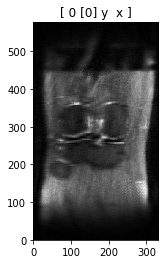

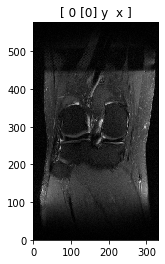

In [98]:
###############################################
# trying to get mr images onto tensorboard, unsuccessful
###############################################

%matplotlib inline
# Let's look at the final produced image
im_est = transforms.tensor_to_complex_np(im_est_gpu.cpu().detach())
im_true = transforms.tensor_to_complex_np(im_true_gpu.cpu().detach())

pl.ImagePlot(im_est) # this is est image
pl.ImagePlot(im_true) # this is true image

# it produces some kind of similar images

In [82]:
def plot_mri(im_true_gpu, im_est_gpu):
    # Let's look at the final produced image
    im_est = transforms.tensor_to_complex_np(im_est_gpu.cpu().detach())
    im_true = transforms.tensor_to_complex_np(im_true_gpu.cpu().detach())

    return pl.ImagePlot(im_est), pl.ImagePlot(im_true)

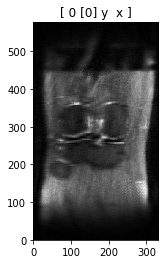

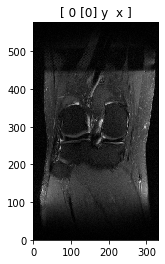

In [84]:
a, b = plot_mri(im_true_gpu, im_est_gpu)

In [87]:
a